In [1]:
import torch as t 
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pylab as plt
from torch.nn.utils import clip_grad_value_
%matplotlib inline
import pickle
from torchvision import datasets, transforms
import tqdm
import os
import sys
sys.path.append('../src/')

In [2]:
import importlib 
import kernel_hypernet as kernel_hypernet
import var_net as var_net
import mnist_utils as utils
importlib.reload(utils)
importlib.reload(var_net)
importlib.reload(kernel_hypernet)



<module 'kernel_hypernet' from '../src/kernel_hypernet.py'>

In [3]:
device = 'cuda' # cuda or cpu
device = t.device(device)
if device == 'cuda':
    t.backends.cudnn.deterministic = True
    t.backends.cudnn.benchmark = False

In [4]:
batch_size = 256
init_log_sigma = -3.0 # логарифм дисперсии вариационного распределения при инициализации
prior_sigma = 1.0 # априорная дисперсия
epoch_num = 50 #количество эпох
lamb = [0.001, 0.01, 0.1,  1, 10, 100.0]
lamb = [t.tensor(l) for l in lamb]
hidden_num = 50 # количество нейронов на скрытом слое
acc_delete = [] 
start_num = 5
path_to_save = 'saved_mnist'
lambda_sample_num = 5
lambda_encode = lambda x: (t.log(x) - np.log(0.001))/(np.log(100.) - np.log(0.001))
if not os.path.exists(path_to_save):
    os.mkdir(path_to_save)
lambda_encode(lamb[0]), lambda_encode(lamb[-1])

(tensor(0.), tensor(1.0000))

In [5]:
# загрузка данных
train_data = torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                                  torchvision.transforms.Lambda(lambda x: x.view(-1))
                              ]))

test_data = torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                                  torchvision.transforms.Lambda(lambda x: x.view(-1))
                              ]))


train_loader = t.utils.data.DataLoader(train_data, batch_size=batch_size, pin_memory=True )
test_loader = t.utils.data.DataLoader(test_data, batch_size=batch_size)





In [9]:
t.manual_seed(0)
kernel_num = 6
for start in range(start_num):                    
        net = var_net.VarNet(kernel_hypernet.VarKernelLayer(784,  hidden_num, kernel_num, prior_sigma=prior_sigma, init_log_sigma=init_log_sigma),
             kernel_hypernet.VarKernelLayer(hidden_num, 10,   kernel_num, 
                                                prior_sigma=prior_sigma, act=lambda x:x, init_log_sigma=init_log_sigma))

        net = net.to(device)
        optim = t.optim.Adam(net.parameters(), lr=5e-4)
        loss_fn = nn.CrossEntropyLoss().to(device)            
        for e in range(epoch_num):
            label = 'epoch {}: '.format(e)                
            utils.train_batches_hypernet(train_loader,  len(train_data), lambda_sample_num,
                  lambda_encode, net, device, loss_fn, optim, label, rep=True, p_gen=lambda p_:p_*5-3)
            if e%5 == 0:
                print (utils.test_acc_hyper(net, device, test_loader, lambda_encode, lamb))
        t.save(net.state_dict(), os.path.join(path_to_save, 'rep_kernel_start_{}.cpk'.format(start)))

epoch 1: [1.546241  2.0130649]:   0%|          | 1/235 [00:00<00:29,  7.95it/s]

{tensor(0.0010): 0.7748, tensor(0.0100): 0.8401, tensor(0.1000): 0.8121, tensor(1): 0.8278, tensor(10): 0.7855, tensor(100.): 0.6876}


epoch 6: [1.0462906 1.5001733]:   0%|          | 1/235 [00:00<00:25,  9.19it/s]

{tensor(0.0010): 0.8997, tensor(0.0100): 0.9181, tensor(0.1000): 0.9172, tensor(1): 0.9154, tensor(10): 0.9191, tensor(100.): 0.9115}


epoch 11: [0.7620072 1.0644193]:   1%|          | 2/235 [00:00<00:23,  9.95it/s]

{tensor(0.0010): 0.926, tensor(0.0100): 0.9399, tensor(0.1000): 0.9356, tensor(1): 0.937, tensor(10): 0.9396, tensor(100.): 0.9271}


epoch 16: [1.0359085 1.4422332]:   0%|          | 1/235 [00:00<00:25,  9.18it/s]

{tensor(0.0010): 0.9353, tensor(0.0100): 0.9517, tensor(0.1000): 0.9497, tensor(1): 0.9493, tensor(10): 0.9516, tensor(100.): 0.9395}


epoch 21: [1.051302  1.4660784]:   1%|          | 2/235 [00:00<00:19, 11.85it/s]

{tensor(0.0010): 0.94, tensor(0.0100): 0.9419, tensor(0.1000): 0.9552, tensor(1): 0.9567, tensor(10): 0.9554, tensor(100.): 0.9379}


epoch 26: [1.1194136 1.6240238]:   0%|          | 1/235 [00:00<00:25,  9.24it/s]

{tensor(0.0010): 0.9512, tensor(0.0100): 0.9607, tensor(0.1000): 0.9578, tensor(1): 0.9596, tensor(10): 0.9585, tensor(100.): 0.9533}


epoch 31: [0.93966675 1.272122  ]:   0%|          | 1/235 [00:00<00:29,  7.85it/s]

{tensor(0.0010): 0.9552, tensor(0.0100): 0.9612, tensor(0.1000): 0.9622, tensor(1): 0.963, tensor(10): 0.9627, tensor(100.): 0.9532}


epoch 36: [0.9375326 1.3861271]:   0%|          | 1/235 [00:00<00:24,  9.70it/s]

{tensor(0.0010): 0.9603, tensor(0.0100): 0.9657, tensor(0.1000): 0.9643, tensor(1): 0.9656, tensor(10): 0.9684, tensor(100.): 0.9567}


epoch 41: [0.85511935 1.2313876 ]:   0%|          | 1/235 [00:00<00:24,  9.52it/s]

{tensor(0.0010): 0.9627, tensor(0.0100): 0.9693, tensor(0.1000): 0.9666, tensor(1): 0.9656, tensor(10): 0.9685, tensor(100.): 0.9579}


epoch 46: [1.067388 1.405892]:   0%|          | 0/235 [00:00<?, ?it/s]

{tensor(0.0010): 0.9644, tensor(0.0100): 0.9693, tensor(0.1000): 0.9667, tensor(1): 0.9696, tensor(10): 0.968, tensor(100.): 0.9582}


epoch 1: [1.5910985 2.139284 ]:   0%|          | 1/235 [00:00<00:35,  6.53it/s]

{tensor(0.0010): 0.8103, tensor(0.0100): 0.8028, tensor(0.1000): 0.8393, tensor(1): 0.8293, tensor(10): 0.8275, tensor(100.): 0.767}


epoch 6: [1.4746398 2.104577 ]:   0%|          | 0/235 [00:00<?, ?it/s]

{tensor(0.0010): 0.9117, tensor(0.0100): 0.9265, tensor(0.1000): 0.9196, tensor(1): 0.9176, tensor(10): 0.9154, tensor(100.): 0.8952}


epoch 11: [0.7321737 1.1327105]:   0%|          | 1/235 [00:00<00:38,  6.01it/s]

{tensor(0.0010): 0.9315, tensor(0.0100): 0.9437, tensor(0.1000): 0.9376, tensor(1): 0.9412, tensor(10): 0.9408, tensor(100.): 0.9289}


epoch 16: [0.9980588 1.444775 ]:   0%|          | 1/235 [00:00<00:25,  9.01it/s]

{tensor(0.0010): 0.9429, tensor(0.0100): 0.9512, tensor(0.1000): 0.9479, tensor(1): 0.9481, tensor(10): 0.9507, tensor(100.): 0.9401}


epoch 21: [0.86833334 1.1738741 ]:   1%|          | 2/235 [00:00<00:21, 10.85it/s]

{tensor(0.0010): 0.9499, tensor(0.0100): 0.9579, tensor(0.1000): 0.9553, tensor(1): 0.9585, tensor(10): 0.9565, tensor(100.): 0.9423}


epoch 26: [0.5599264 0.7821826]:   0%|          | 1/235 [00:00<00:46,  5.02it/s]

{tensor(0.0010): 0.9497, tensor(0.0100): 0.9634, tensor(0.1000): 0.9556, tensor(1): 0.961, tensor(10): 0.9615, tensor(100.): 0.9452}


epoch 31: [0.9695153 1.4333547]:   0%|          | 1/235 [00:00<00:31,  7.55it/s]

{tensor(0.0010): 0.9557, tensor(0.0100): 0.962, tensor(0.1000): 0.9597, tensor(1): 0.9645, tensor(10): 0.9607, tensor(100.): 0.9503}


epoch 36: [1.0354996 1.4410566]:   0%|          | 0/235 [00:00<?, ?it/s]

{tensor(0.0010): 0.9616, tensor(0.0100): 0.9655, tensor(0.1000): 0.9639, tensor(1): 0.9624, tensor(10): 0.9654, tensor(100.): 0.9475}


epoch 41: [0.92254305 1.2833527 ]:   1%|          | 2/235 [00:00<00:20, 11.30it/s]

{tensor(0.0010): 0.9611, tensor(0.0100): 0.965, tensor(0.1000): 0.9637, tensor(1): 0.9672, tensor(10): 0.968, tensor(100.): 0.9585}


epoch 46: [0.76831055 1.1157205 ]:   0%|          | 1/235 [00:00<00:24,  9.44it/s]

{tensor(0.0010): 0.9633, tensor(0.0100): 0.9685, tensor(0.1000): 0.9655, tensor(1): 0.9693, tensor(10): 0.9684, tensor(100.): 0.9615}


epoch 1: [1.2561451 1.6031811]:   0%|          | 1/235 [00:00<00:26,  8.95it/s]

{tensor(0.0010): 0.772, tensor(0.0100): 0.8238, tensor(0.1000): 0.7991, tensor(1): 0.828, tensor(10): 0.8491, tensor(100.): 0.7426}


epoch 6: [0.761619  0.9965599]:   0%|          | 1/235 [00:00<00:30,  7.74it/s]

{tensor(0.0010): 0.8974, tensor(0.0100): 0.917, tensor(0.1000): 0.9115, tensor(1): 0.9204, tensor(10): 0.9105, tensor(100.): 0.9038}


epoch 11: [1.2291075 1.6421379]:   1%|          | 2/235 [00:00<00:20, 11.34it/s]

{tensor(0.0010): 0.9261, tensor(0.0100): 0.933, tensor(0.1000): 0.9377, tensor(1): 0.9399, tensor(10): 0.9359, tensor(100.): 0.9245}


epoch 16: [0.8135708 1.2670574]:   0%|          | 1/235 [00:00<00:28,  8.34it/s]

{tensor(0.0010): 0.9377, tensor(0.0100): 0.948, tensor(0.1000): 0.9495, tensor(1): 0.949, tensor(10): 0.9435, tensor(100.): 0.9364}


epoch 21: [0.9640039 1.4410976]:   0%|          | 1/235 [00:00<00:29,  7.81it/s]

{tensor(0.0010): 0.9436, tensor(0.0100): 0.9542, tensor(0.1000): 0.9514, tensor(1): 0.9517, tensor(10): 0.9516, tensor(100.): 0.948}


epoch 26: [1.0488217 1.4516037]:   0%|          | 1/235 [00:00<00:25,  9.20it/s]

{tensor(0.0010): 0.9525, tensor(0.0100): 0.9592, tensor(0.1000): 0.9541, tensor(1): 0.9614, tensor(10): 0.9596, tensor(100.): 0.9468}


epoch 31: [0.49245873 0.7910086 ]:   0%|          | 1/235 [00:00<00:25,  9.29it/s]

{tensor(0.0010): 0.9562, tensor(0.0100): 0.9614, tensor(0.1000): 0.96, tensor(1): 0.9623, tensor(10): 0.9613, tensor(100.): 0.9519}


epoch 36: [0.9668873 1.3990691]:   0%|          | 1/235 [00:00<00:29,  7.91it/s]

{tensor(0.0010): 0.9597, tensor(0.0100): 0.9652, tensor(0.1000): 0.9612, tensor(1): 0.9619, tensor(10): 0.9638, tensor(100.): 0.949}


epoch 41: [0.6150049 1.0082219]:   0%|          | 1/235 [00:00<00:28,  8.14it/s]

{tensor(0.0010): 0.9631, tensor(0.0100): 0.9675, tensor(0.1000): 0.96, tensor(1): 0.9673, tensor(10): 0.9651, tensor(100.): 0.9604}


epoch 46: [0.7491738 0.9827979]:   0%|          | 1/235 [00:00<00:23,  9.83it/s]

{tensor(0.0010): 0.9635, tensor(0.0100): 0.9667, tensor(0.1000): 0.9636, tensor(1): 0.9673, tensor(10): 0.9649, tensor(100.): 0.957}


epoch 1: [1.3548615 1.7104582]:   0%|          | 1/235 [00:00<00:26,  8.82it/s]

{tensor(0.0010): 0.7549, tensor(0.0100): 0.7912, tensor(0.1000): 0.7555, tensor(1): 0.815, tensor(10): 0.8303, tensor(100.): 0.7599}


epoch 6: [1.2774533 1.7117999]:   0%|          | 1/235 [00:00<00:31,  7.41it/s]

{tensor(0.0010): 0.9025, tensor(0.0100): 0.9132, tensor(0.1000): 0.9201, tensor(1): 0.9085, tensor(10): 0.9213, tensor(100.): 0.8977}


epoch 11: [1.1660159 1.5394466]:   0%|          | 1/235 [00:00<00:38,  6.01it/s]

{tensor(0.0010): 0.9207, tensor(0.0100): 0.9362, tensor(0.1000): 0.9436, tensor(1): 0.9335, tensor(10): 0.934, tensor(100.): 0.9284}


epoch 16: [0.9961057 1.3646234]:   0%|          | 1/235 [00:00<00:45,  5.13it/s]

{tensor(0.0010): 0.9334, tensor(0.0100): 0.9461, tensor(0.1000): 0.9491, tensor(1): 0.9466, tensor(10): 0.9463, tensor(100.): 0.9322}


epoch 21: [1.243294 1.749252]:   1%|          | 2/235 [00:00<00:18, 12.46it/s]

{tensor(0.0010): 0.9433, tensor(0.0100): 0.9556, tensor(0.1000): 0.9568, tensor(1): 0.9548, tensor(10): 0.9546, tensor(100.): 0.9486}


epoch 26: [0.7305436 1.0433257]:   0%|          | 1/235 [00:00<00:24,  9.63it/s]

{tensor(0.0010): 0.9306, tensor(0.0100): 0.9574, tensor(0.1000): 0.9597, tensor(1): 0.9572, tensor(10): 0.9586, tensor(100.): 0.9443}


epoch 31: [1.132447 1.539502]:   0%|          | 1/235 [00:00<00:29,  7.97it/s]

{tensor(0.0010): 0.9564, tensor(0.0100): 0.9632, tensor(0.1000): 0.9638, tensor(1): 0.9585, tensor(10): 0.9611, tensor(100.): 0.9566}


epoch 36: [0.9442679 1.36763  ]:   0%|          | 1/235 [00:00<00:24,  9.70it/s]

{tensor(0.0010): 0.9606, tensor(0.0100): 0.9666, tensor(0.1000): 0.9635, tensor(1): 0.9647, tensor(10): 0.9651, tensor(100.): 0.9592}


epoch 41: [1.0015315 1.3685367]:   0%|          | 1/235 [00:00<00:27,  8.47it/s]

{tensor(0.0010): 0.9645, tensor(0.0100): 0.9664, tensor(0.1000): 0.9644, tensor(1): 0.9647, tensor(10): 0.9647, tensor(100.): 0.9616}


epoch 46: [0.8660266 1.1985333]:   0%|          | 1/235 [00:00<00:26,  8.76it/s]

{tensor(0.0010): 0.9658, tensor(0.0100): 0.9695, tensor(0.1000): 0.9689, tensor(1): 0.9689, tensor(10): 0.9655, tensor(100.): 0.9659}


epoch 1: [1.4443262 1.8604949]:   0%|          | 1/235 [00:00<00:24,  9.65it/s]

{tensor(0.0010): 0.7978, tensor(0.0100): 0.8345, tensor(0.1000): 0.8286, tensor(1): 0.8329, tensor(10): 0.8231, tensor(100.): 0.7729}


epoch 6: [0.8576819 1.2076615]:   0%|          | 1/235 [00:00<00:24,  9.67it/s]

{tensor(0.0010): 0.907, tensor(0.0100): 0.9087, tensor(0.1000): 0.924, tensor(1): 0.9134, tensor(10): 0.9123, tensor(100.): 0.8956}


epoch 11: [1.0665152 1.4823673]:   0%|          | 1/235 [00:00<00:24,  9.67it/s]  

{tensor(0.0010): 0.9231, tensor(0.0100): 0.9403, tensor(0.1000): 0.938, tensor(1): 0.933, tensor(10): 0.935, tensor(100.): 0.9283}


epoch 16: [0.8609527 1.2141126]:   0%|          | 1/235 [00:00<00:30,  7.68it/s]  

{tensor(0.0010): 0.9389, tensor(0.0100): 0.947, tensor(0.1000): 0.9535, tensor(1): 0.942, tensor(10): 0.9508, tensor(100.): 0.9384}


epoch 21: [0.9279102 1.25758  ]:   1%|          | 2/235 [00:00<00:21, 11.05it/s]

{tensor(0.0010): 0.9465, tensor(0.0100): 0.9544, tensor(0.1000): 0.9553, tensor(1): 0.9524, tensor(10): 0.9549, tensor(100.): 0.9427}


epoch 26: [0.69871503 1.0264688 ]:   0%|          | 1/235 [00:00<00:25,  9.00it/s]

{tensor(0.0010): 0.9492, tensor(0.0100): 0.9588, tensor(0.1000): 0.9601, tensor(1): 0.9566, tensor(10): 0.9582, tensor(100.): 0.9493}


epoch 31: [0.9505499 1.3338816]:   1%|          | 2/235 [00:00<00:19, 12.05it/s]

{tensor(0.0010): 0.9573, tensor(0.0100): 0.9602, tensor(0.1000): 0.9619, tensor(1): 0.9594, tensor(10): 0.9618, tensor(100.): 0.9539}


epoch 36: [0.82388973 1.1884817 ]:   0%|          | 1/235 [00:00<00:23,  9.85it/s]

{tensor(0.0010): 0.9588, tensor(0.0100): 0.9653, tensor(0.1000): 0.9604, tensor(1): 0.964, tensor(10): 0.9643, tensor(100.): 0.9543}


epoch 41: [0.85483724 1.2504431 ]:   1%|          | 2/235 [00:00<00:19, 11.81it/s]

{tensor(0.0010): 0.9607, tensor(0.0100): 0.9622, tensor(0.1000): 0.9641, tensor(1): 0.9637, tensor(10): 0.9653, tensor(100.): 0.9496}


epoch 46: [0.2418396 0.3421455]:   0%|          | 1/235 [00:00<00:25,  9.04it/s]

{tensor(0.0010): 0.9644, tensor(0.0100): 0.9671, tensor(0.1000): 0.9686, tensor(1): 0.9647, tensor(10): 0.9649, tensor(100.): 0.958}


epoch 49: [0.7956093 1.1466589]: 100%|██████████| 235/235 [00:20<00:00, 11.60it/s]  


In [10]:
net = var_net.VarNet(var_net.VarLayer(784,  hidden_num, 
                                            prior_sigma = prior_sigma, init_log_sigma=init_log_sigma), 
                                 var_net.VarLayer(hidden_num, 10, prior_sigma=prior_sigma,  init_log_sigma=init_log_sigma,
                                          act=lambda x:x)).to(device)    
hnet =  var_net.VarNet(kernel_hypernet.VarKernelLayer(784,  hidden_num, kernel_num, prior_sigma=prior_sigma, init_log_sigma=init_log_sigma),
             kernel_hypernet.VarKernelLayer(hidden_num, 10,   kernel_num, 
                                                prior_sigma=prior_sigma, act=lambda x:x, init_log_sigma=init_log_sigma))

hnet = hnet.to(device)
net = net.to(device)
lam_results = {}
for lam in lamb:
    lam_results[lam] = []
    for s in range(start_num):        
        print (lam, s)
        hnet.load_state_dict(t.load(os.path.join(path_to_save, 'rep_kernel_start_{}.cpk'.format(s))))        
        utils.net_copy(hnet, net, lambda_encode(t.ones(1).to(device)[0]*lam))
        lam_results[lam].append(utils.delete_10(net, device, lambda:utils.test_acc_net(net, device, test_loader)))
lam_results = {float(k):lam_results[k] for k in lam_results}
import json
with open(os.path.join(path_to_save, 'results_rep_kernel.json'),'w') as out:
    out.write(json.dumps(lam_results))  

tensor(0.0010) 0
tensor(0.0010) 1
tensor(0.0010) 2
tensor(0.0010) 3
tensor(0.0010) 4
tensor(0.0100) 0
tensor(0.0100) 1
tensor(0.0100) 2
tensor(0.0100) 3
tensor(0.0100) 4
tensor(0.1000) 0
tensor(0.1000) 1
tensor(0.1000) 2
tensor(0.1000) 3
tensor(0.1000) 4
tensor(1) 0
tensor(1) 1
tensor(1) 2
tensor(1) 3
tensor(1) 4
tensor(10) 0
tensor(10) 1
tensor(10) 2
tensor(10) 3
tensor(10) 4
tensor(100.) 0
tensor(100.) 1
tensor(100.) 2
tensor(100.) 3
tensor(100.) 4


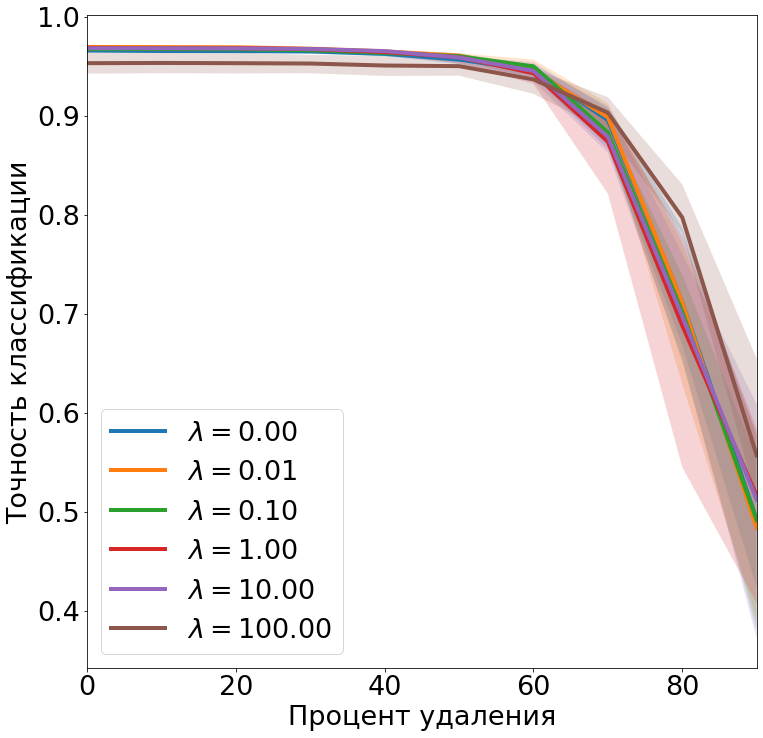

In [11]:
proc = [0,10,20,30,40,50,60,70,80,90]
plt.rcParams['figure.figsize'] = 12, 12
plt.rcParams.update({'font.size': 27})
plt.rc('lines', linewidth=4)
    
    
for lam in lamb:
    lam = float(lam)
    lam_str = "{:10.2f}".format(lam)

    plt.fill_between(proc, np.min(lam_results[lam], 0), np.max(lam_results[lam], 0), alpha=0.2)
    plt.plot(proc, np.mean(lam_results[lam], 0), label='$\lambda={}$'.format(lam_str))
plt.ylabel('Точность классификации', fontsize = 27)
plt.xlabel('Процент удаления', fontsize = 27)
plt.tick_params(axis='both', which='major', labelsize=27)
plt.legend(loc='lower left')
plt.autoscale(enable=True, axis='x', tight=True)
plt.savefig('Kernel_rep')
#plt.show()
